In [1]:
import pandas as pd
import numpy as np

import os
import sys

# librosa is a Python library for analyzing audio and music. It can be used to extract the data from the audio files we will see it later.
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# to play the audio files
from IPython.display import Audio

import tensorflow as tf
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)


2024-04-13 11:41:47.930679: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-13 11:41:47.930833: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-13 11:41:48.127163: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Paths for data.
Ravdess = "/kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/"
Crema = "/kaggle/input/cremad/AudioWAV/"
Tess = "/kaggle/input/toronto-emotional-speech-set-tess/tess toronto emotional speech set data/TESS Toronto emotional speech set data/"
Savee = "/kaggle/input/surrey-audiovisual-expressed-emotion-savee/ALL/"

In [3]:
import os
import pandas as pd

ravdess_directory_list = os.listdir(Ravdess)

file_emotion = []
file_path = []
for dir in ravdess_directory_list:
    # as there are 20 different actors in our previous directory we need to extract files for each actor.
    actor = os.listdir(os.path.join(Ravdess, dir))
    for file in actor:
        part = file.split('.')[0]
        part = part.split('-')
        # third part in each file represents the emotion associated with that file.
        file_emotion.append(int(part[2]))
        file_path.append(os.path.join(Ravdess, dir, file))
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Ravdess_df = pd.concat([emotion_df, path_df], axis=1)

# changing integers to actual emotions.
Ravdess_df.Emotions.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}, inplace=True)
Ravdess_df.head()


,Emotions,Path
0,surprise,/kaggle/input/ravdess-emotional-speech-audio/a...
1,neutral,/kaggle/input/ravdess-emotional-speech-audio/a...
2,disgust,/kaggle/input/ravdess-emotional-speech-audio/a...
3,disgust,/kaggle/input/ravdess-emotional-speech-audio/a...
4,neutral,/kaggle/input/ravdess-emotional-speech-audio/a...


In [4]:
crema_directory_list = os.listdir(Crema)

file_emotion = []
file_path = []

for file in crema_directory_list:
    # storing file paths
    file_path.append(os.path.join(Crema, file))
    # storing file emotions
    part = file.split('_')
    if part[2] == 'SAD':
        file_emotion.append('sad')
    elif part[2] == 'ANG':
        file_emotion.append('angry')
    elif part[2] == 'DIS':
        file_emotion.append('disgust')
    elif part[2] == 'FEA':
        file_emotion.append('fear')
    elif part[2] == 'HAP':
        file_emotion.append('happy')
    elif part[2] == 'NEU':
        file_emotion.append('neutral')
    else:
        file_emotion.append('Unknown')
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Crema_df = pd.concat([emotion_df, path_df], axis=1)
Crema_df.head()


,Emotions,Path
0,disgust,/kaggle/input/cremad/AudioWAV/1028_TSI_DIS_XX.wav
1,happy,/kaggle/input/cremad/AudioWAV/1075_IEO_HAP_LO.wav
2,happy,/kaggle/input/cremad/AudioWAV/1084_ITS_HAP_XX.wav
3,disgust,/kaggle/input/cremad/AudioWAV/1067_IWW_DIS_XX.wav
4,disgust,/kaggle/input/cremad/AudioWAV/1066_TIE_DIS_XX.wav


In [5]:
tess_directory_list = os.listdir(Tess)

file_emotion = []
file_path = []

for dir in tess_directory_list:
    directories = os.listdir(os.path.join(Tess, dir))
    for file in directories:
        part = file.split('.')[0]
        part = part.split('_')[2]
        if part == 'ps':
            file_emotion.append('surprise')
        else:
            file_emotion.append(part)
        file_path.append(os.path.join(Tess, dir, file))
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Tess_df = pd.concat([emotion_df, path_df], axis=1)
Tess_df.head()


,Emotions,Path
0,fear,/kaggle/input/toronto-emotional-speech-set-tes...
1,fear,/kaggle/input/toronto-emotional-speech-set-tes...
2,fear,/kaggle/input/toronto-emotional-speech-set-tes...
3,fear,/kaggle/input/toronto-emotional-speech-set-tes...
4,fear,/kaggle/input/toronto-emotional-speech-set-tes...


In [6]:
savee_directory_list = os.listdir(Savee)

file_emotion = []
file_path = []

for file in savee_directory_list:
    file_path.append(os.path.join(Savee, file))
    part = file.split('_')[1]
    ele = part[:-6]
    if ele == 'a':
        file_emotion.append('angry')
    elif ele == 'd':
        file_emotion.append('disgust')
    elif ele == 'f':
        file_emotion.append('fear')
    elif ele == 'h':
        file_emotion.append('happy')
    elif ele == 'n':
        file_emotion.append('neutral')
    elif ele == 'sa':
        file_emotion.append('sad')
    else:
        file_emotion.append('surprise')
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Savee_df = pd.concat([emotion_df, path_df], axis=1)
Savee_df.head()


,Emotions,Path
0,happy,/kaggle/input/surrey-audiovisual-expressed-emo...
1,fear,/kaggle/input/surrey-audiovisual-expressed-emo...
2,happy,/kaggle/input/surrey-audiovisual-expressed-emo...
3,disgust,/kaggle/input/surrey-audiovisual-expressed-emo...
4,angry,/kaggle/input/surrey-audiovisual-expressed-emo...


In [7]:
# creating Dataframe using all the 4 dataframes we created so far.
data_path = pd.concat([Ravdess_df, Crema_df, Tess_df, Savee_df], axis = 0)
data_path.to_csv("data_path.csv",index=False)
data_path.head()

,Emotions,Path
0,surprise,/kaggle/input/ravdess-emotional-speech-audio/a...
1,neutral,/kaggle/input/ravdess-emotional-speech-audio/a...
2,disgust,/kaggle/input/ravdess-emotional-speech-audio/a...
3,disgust,/kaggle/input/ravdess-emotional-speech-audio/a...
4,neutral,/kaggle/input/ravdess-emotional-speech-audio/a...


In [8]:
# plt.title('Count of Emotions', size=16)
# sns.countplot(data_path.Emotions)
# plt.ylabel('Count', size=12)
# plt.xlabel('Emotions', size=12)
# sns.despine(top=True, right=True, left=False, bottom=False)
# plt.show()


In [9]:
def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title('Waveplot for audio with {} emotion'.format(e), size=15)
    librosa.display.waveshow(data, sr=sr)
    plt.show()

def create_spectrogram(data, sr, e):
    # stft function converts the data into short term fourier transform
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for audio with {} emotion'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')   
    #librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar()

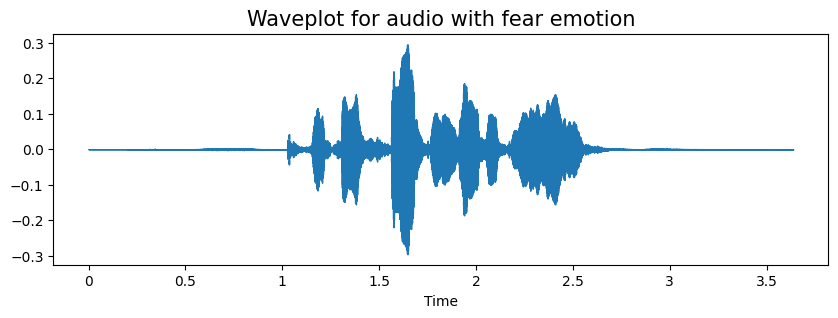

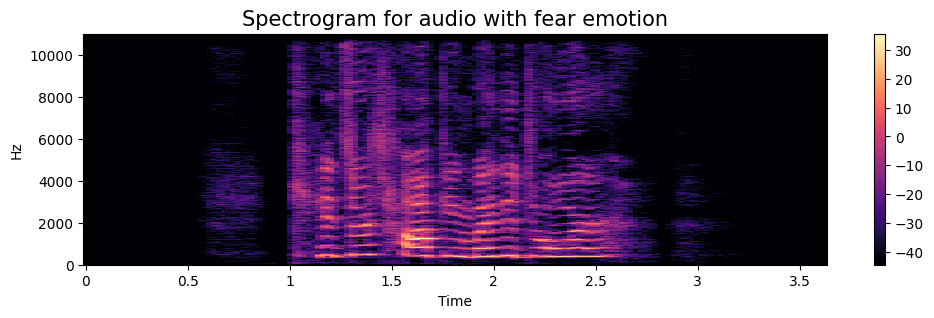

In [10]:
emotion='fear'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

In [11]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)

# taking any example and checking for techniques.
path = np.array(data_path.Path)[1]
data, sample_rate = librosa.load(path)

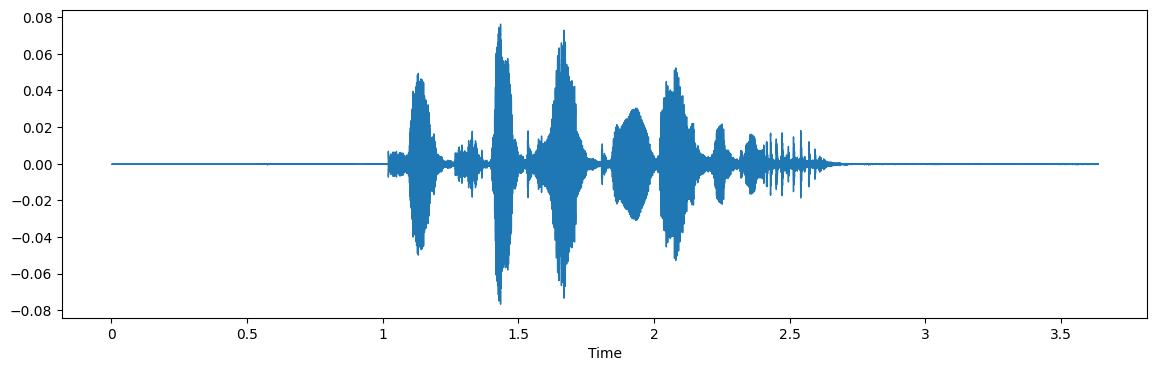

In [12]:
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=data, sr=sample_rate)
Audio(path)

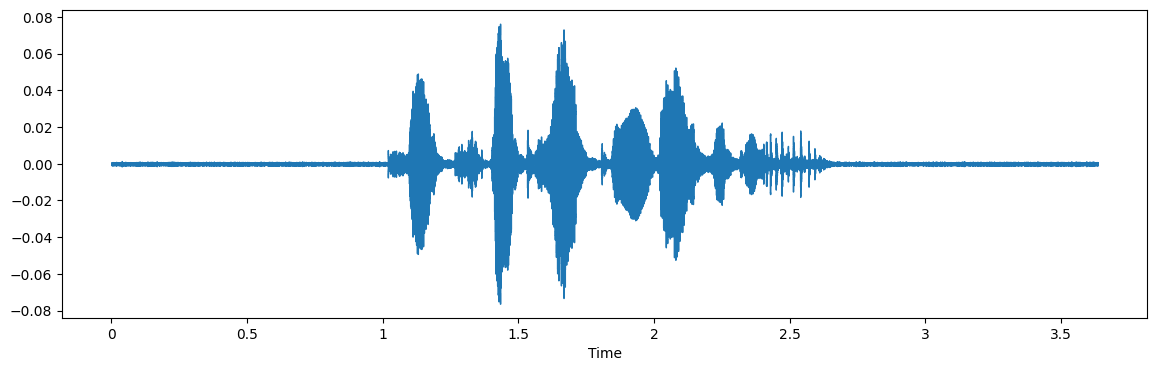

In [13]:
x = noise(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

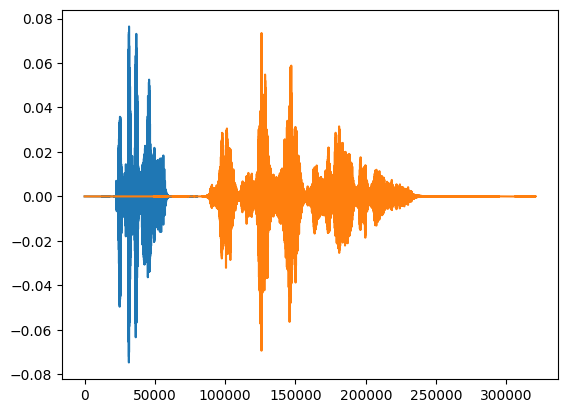

In [14]:
import numpy as np, librosa
x = data
y = librosa.effects.time_stretch(data, rate=4000/16000)
plt.plot(x)  # plotted in blue
plt.plot(y) 

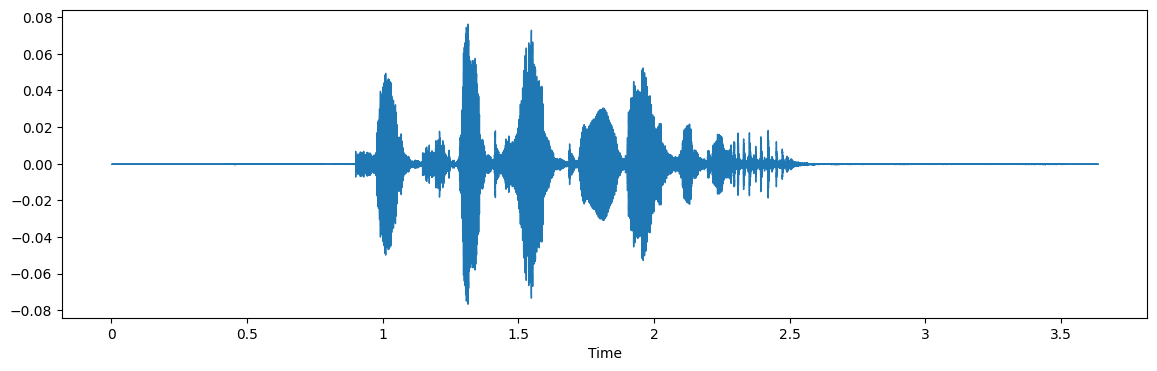

In [15]:
x = shift(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

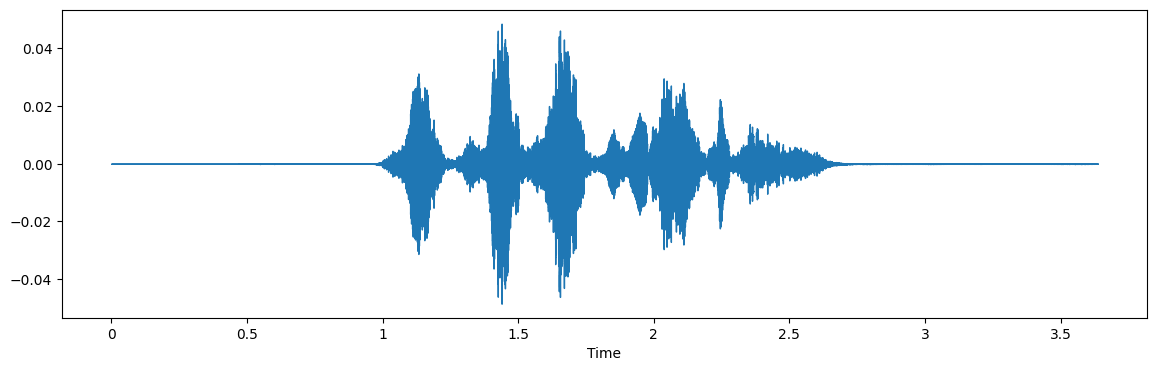

In [16]:
# Define the number of semitones to shift (positive for higher pitch, negative for lower)
semitones = 10# Increase pitch by one octave

# Apply pitch shift
pitched_x = librosa.effects.pitch_shift(y=data, sr=sample_rate, n_steps=semitones)

# Plot and play the pitch-shifted audio
plt.figure(figsize=(14, 4))
librosa.display.waveshow(y=pitched_x, sr=sample_rate)  # Use waveshow for better visualization
Audio(pitched_x, rate=sample_rate)

In [17]:
def extract_features(data, sample_rate):
    # ZCR (Zero-Crossing Rate)
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)

    # Chroma Features
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)

    # MFCC (Mel-frequency cepstral coefficients)
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)

    # RMS (Root Mean Square)
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)

    # Mel Spectrogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)

    # Return all features combined
    return np.hstack((zcr, chroma_stft, mfcc, rms, mel))

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate=rate)

def pitch(data, sample_rate, n_steps=2):
    return librosa.effects.pitch_shift(data, n_steps=n_steps, sr=sample_rate)

In [18]:
X, Y = [], []

for path, emotion in zip(data_path.Path, data_path.Emotions):
    # Load audio file
    data, sample_rate = librosa.load(path, sr=None)
    
    # Extract features
    feature = extract_features(data, sample_rate)
    
    # Append features to X
    X.append(feature)
    
    # Append emotion label to Y
    Y.append(emotion)

In [19]:
X = np.array(X)
Y = np.array(Y)

# Save the features and labels separately
np.save('features.npy', X)
np.save('labels.npy', Y)

In [20]:
import numpy as np

# Load features and labels
X = np.load('features.npy')
Y = np.load('labels.npy')

# Now you can use X and Y for training your models or any other task


In [21]:
len(X), len(Y), data_path.Path.shape

(12162, 12162, (12162,))

In [22]:
Features = pd.DataFrame(X)
Features['labels'] = Y
Features.to_csv('features.csv', index=False)
Features.head()

,0,1,2,3,4,5,6,7,8,9,...,153,154,155,156,157,158,159,160,161,labels
0,0.077356,0.597668,0.569676,0.552510,0.519775,0.518444,0.568923,0.603412,0.593776,0.584967,...,6.448764e-06,4.270611e-06,1.929793e-06,1.382053e-06,1.325920e-06,1.724247e-06,6.659272e-07,5.710148e-08,7.411737e-09,surprise
1,0.055098,0.563816,0.541095,0.528790,0.569641,0.562325,0.583438,0.605805,0.628712,0.625144,...,5.245981e-07,4.794794e-07,2.306867e-07,8.584893e-08,5.591993e-08,5.252700e-08,2.302577e-08,6.673671e-09,5.952105e-09,neutral
2,0.067452,0.677283,0.641305,0.614089,0.622537,0.659375,0.690025,0.701118,0.662260,0.660558,...,3.632615e-06,3.099354e-06,1.702521e-06,1.313403e-06,9.251826e-07,5.764591e-07,2.606133e-07,2.520313e-08,7.357648e-09,disgust
3,0.059311,0.530809,0.473593,0.469681,0.502935,0.530212,0.572539,0.616313,0.606503,0.600060,...,1.507578e-07,7.862435e-08,6.800079e-08,6.680273e-08,4.742554e-08,2.898010e-08,1.576516e-08,6.809927e-09,6.404414e-09,disgust
4,0.064246,0.634861,0.619065,0.652576,0.645365,0.668260,0.692250,0.706847,0.696286,0.664889,...,1.093231e-06,7.725272e-07,5.356151e-07,3.585070e-07,2.600881e-07,2.135108e-07,7.362033e-08,9.853049e-09,6.758268e-09,neutral


In [23]:
X = Features.iloc[: ,:-1].values
Y = Features['labels'].values

In [24]:
# As this is a multiclass classification problem onehotencoding our Y.
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [25]:
# splitting data
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((9121, 162), (9121, 8), (3041, 162), (3041, 8))

In [26]:
# scaling our data with sklearn's Standard scaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((9121, 162), (9121, 8), (3041, 162), (3041, 8))

In [27]:
# making our data compatible to model.
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((9121, 162, 1), (9121, 8), (3041, 162, 1), (3041, 8))

In [28]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout

model = Sequential()
model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=5, strides=2, padding='same'))

model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides=2, padding='same'))

model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides=2, padding='same'))
model.add(Dropout(0.2))

model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides=2, padding='same'))

model.add(Flatten())
model.add(Dense(units=32, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(units=8, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 162, 256)       │         1,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 81, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 81, 256)        │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 41, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 41, 128)        │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 21, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 21, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 21, 64)         │        41,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 11, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 704)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │        22,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │           264 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 557,288 (2.13 MB)

 Trainable params: 557,288 (2.13 MB)

 Non-trainable params: 0 (0.00 B)

In [29]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Define the model with increased complexity
model = Sequential([
    Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)),
    MaxPooling1D(pool_size=2, strides=2),
    Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'),
    MaxPooling1D(pool_size=2, strides=2),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),  # Add dropout layer with dropout rate of 0.5
    Dense(128, activation='relu'),
    Dense(8, activation='softmax')  # Ensure output layer matches number of classes (10 in this case)
])

# Compile the model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Define ReduceLROnPlateau callback
rlrp = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.00001)

# Train the model with GPU support
with tf.device('/GPU:0'):
    history = model.fit(x_train, y_train, batch_size=64, epochs=50, validation_data=(x_test, y_test), callbacks=[rlrp])


Epoch 1/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 22s 140ms/step - accuracy: 0.3350 - loss: 1.6613 - val_accuracy: 0.5209 - val_loss: 1.1994 - learning_rate: 0.0010
Epoch 2/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 20s 140ms/step - accuracy: 0.5153 - loss: 1.1965 - val_accuracy: 0.5419 - val_loss: 1.1347 - learning_rate: 0.0010
Epoch 3/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 21s 142ms/step - accuracy: 0.5712 - loss: 1.1124 - val_accuracy: 0.5636 - val_loss: 1.0900 - learning_rate: 0.0010
Epoch 4/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 20s 142ms/step - accuracy: 0.5915 - loss: 1.0409 - val_accuracy: 0.5788 - val_loss: 1.0634 - learning_rate: 0.0010
Epoch 5/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 20s 141ms/step - accuracy: 0.6172 - loss: 0.9830 - val_accuracy: 0.5827 - val_loss: 1.0540 - learning_rate: 0.0010
Epoch 6/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 21s 141ms/step - accuracy: 0.6381 - loss: 0.9299 - val_accuracy: 0.5965 - val_loss: 1.0563 - learning_rate: 0.0010
Epoch 7/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 20s 138ms/step - accuracy: 0.6

96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.6510 - loss: 1.4655
Accuracy of our model on test data :  63.26866149902344 %


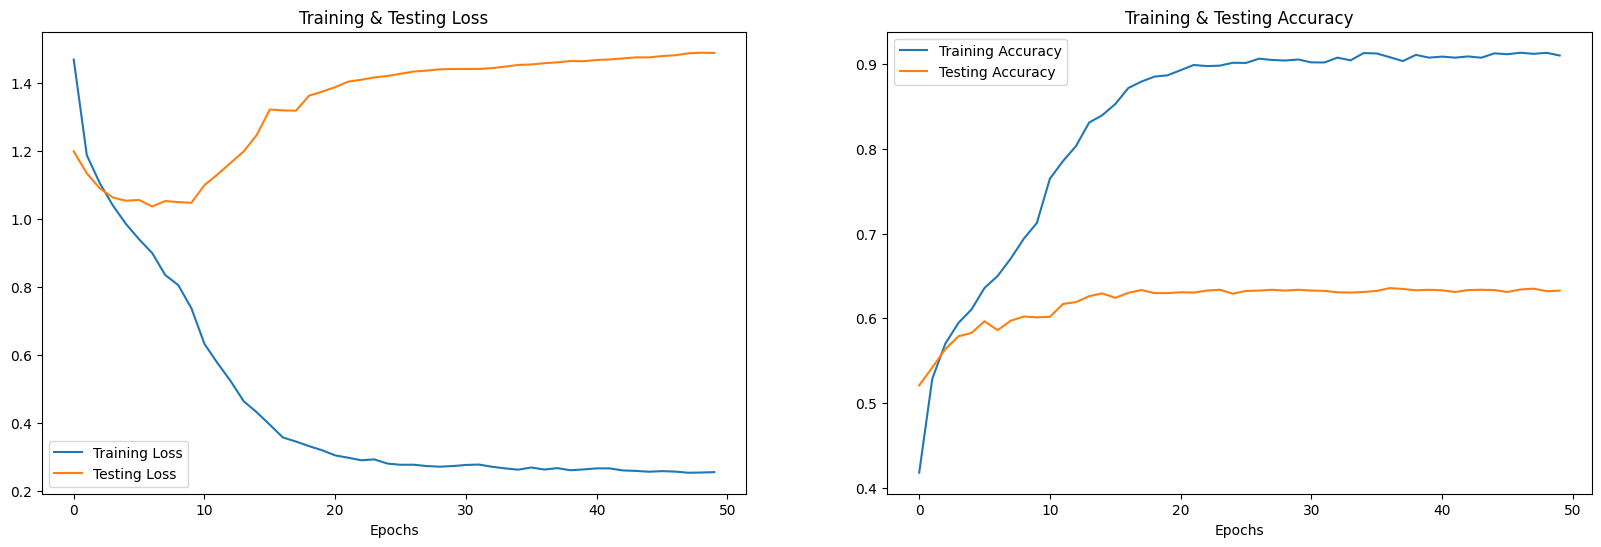

In [30]:
print("Accuracy of our model on test data : " , model.evaluate(x_test,y_test)[1]*100 , "%")

epochs = [i for i in range(50)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [31]:
import tensorflow as tf
tf.compat.v1.reset_default_graph()


In [32]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


Num GPUs Available:  0


In [33]:
import tensorflow as tf
tf.keras.backend.clear_session()


In [34]:
pip list


Package                                  Version
---------------------------------------- ------------------
absl-py                                  1.4.0
accelerate                               0.28.0
access                                   1.1.9
affine                                   2.4.0
aiobotocore                              2.12.2
aiofiles                                 22.1.0
aiohttp                                  3.9.1
aiohttp-cors                             0.7.0
aioitertools                             0.11.0
aiorwlock                                1.3.0
aiosignal                                1.3.1
aiosqlite                                0.19.0
albumentations                           1.4.0
alembic                                  1.13.1
altair                                   5.3.0
annotated-types                          0.6.0
annoy                                    1.17.3
anyio                                    4.2.0
apache-beam                           

In [35]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Define the model with LSTM layers
model = Sequential([
    LSTM(128, 
         input_shape=(x_train.shape[1], 1), return_sequences=True),
    Dropout(0.5),
    LSTM(128),
    Dense(128, activation='relu'),
    Dense(8, activation='softmax')  # Ensure output layer matches number of classes (8 in this case)
])

# Compile the model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Define ReduceLROnPlateau callback
rlrp = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.00001)

# Train the model with GPU support
with tf.device('/GPU:0'):
    history = model.fit(x_train, y_train, batch_size=64, epochs=50, validation_data=(x_test, y_test), callbacks=[rlrp])


Epoch 1/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 83s 553ms/step - accuracy: 0.2439 - loss: 1.8902 - val_accuracy: 0.2614 - val_loss: 1.7970 - learning_rate: 0.0010
Epoch 2/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 77s 516ms/step - accuracy: 0.2461 - loss: 1.8237 - val_accuracy: 0.3065 - val_loss: 1.7256 - learning_rate: 0.0010
Epoch 3/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 82s 514ms/step - accuracy: 0.2918 - loss: 1.7529 - val_accuracy: 0.3196 - val_loss: 1.7252 - learning_rate: 0.0010
Epoch 4/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 77s 536ms/step - accuracy: 0.3066 - loss: 1.7201 - val_accuracy: 0.3305 - val_loss: 1.6556 - learning_rate: 0.0010
Epoch 5/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 83s 543ms/step - accuracy: 0.3382 - loss: 1.6676 - val_accuracy: 0.3505 - val_loss: 1.6382 - learning_rate: 0.0010
Epoch 6/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 85s 567ms/step - accuracy: 0.3544 - loss: 1.6370 - val_accuracy: 0.3808 - val_loss: 1.6052 - learning_rate: 0.0010
Epoch 7/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 80s 556ms/step - accuracy: 0.3

In [36]:
# Updated CNN model with increased complexity
def create_cnn_model(input_shape):
    model = Sequential([
        Conv1D(512, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=input_shape),
        MaxPooling1D(pool_size=2, strides=2),
        Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'),
        MaxPooling1D(pool_size=2, strides=2),
        Conv1D(128, kernel_size=3, strides=1, padding='same', activation='relu'),
        MaxPooling1D(pool_size=2, strides=2),
        Flatten(),
        Dense(1024, activation='relu'),
        Dropout(0.5),
        Dense(512, activation='relu'),
        Dense(8, activation='softmax')
    ])
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Updated LSTM model with increased complexity
def create_lstm_model(input_shape):
    model = Sequential([
        LSTM(256, input_shape=input_shape, return_sequences=True),
        Dropout(0.5),
        LSTM(256),
        Dense(256, activation='relu'),
        Dense(8, activation='softmax')
    ])
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Re-instantiate CNN and LSTM models with increased complexity
cnn_model = create_cnn_model(x_train.shape[1:])
lstm_model = create_lstm_model(x_train.shape[1:])


In [37]:
from tensorflow.keras.layers import Concatenate

# Define input shapes
cnn_input_shape = (x_train.shape[1], x_train.shape[2])
lstm_input_shape = (x_train.shape[1], x_train.shape[2])

# Define mirrored strategy for distributing across multiple GPUs
strategy = tf.distribute.MirroredStrategy()

print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

# Open a strategy scope.
with strategy.scope():
    # Instantiate CNN model
    cnn_model = create_cnn_model(cnn_input_shape)

    # Instantiate LSTM model
    lstm_model = create_lstm_model(lstm_input_shape)

    # Call models with dummy input to define inputs
    cnn_input = tf.keras.Input(shape=cnn_input_shape)
    lstm_input = tf.keras.Input(shape=lstm_input_shape)

    # Call CNN model within the strategy scope
    cnn_output = cnn_model(cnn_input)
    
    # Call LSTM model within the strategy scope
    lstm_output = lstm_model(lstm_input)

    # Merge the outputs of CNN and LSTM models
    merged_output = Concatenate()([cnn_output, lstm_output])

    # Additional layers for further processing
    dense_layer = Dense(128, activation='relu')(merged_output)
    output_layer = Dense(8, activation='softmax')(dense_layer)

    # Create the ensemble model
    ensemble_model = tf.keras.Model(inputs=[cnn_input, lstm_input], outputs=output_layer)

    # Compile the ensemble model
    ensemble_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Train the ensemble model
    ensemble_history = ensemble_model.fit([x_train, x_train], y_train, batch_size=64, epochs=50, validation_data=([x_test, x_test], y_test))


Number of devices: 1
Epoch 1/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 265s 2s/step - accuracy: 0.1691 - loss: 1.9951 - val_accuracy: 0.1753 - val_loss: 1.9467
Epoch 2/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 267s 2s/step - accuracy: 0.1801 - loss: 1.9523 - val_accuracy: 0.1815 - val_loss: 1.9472
Epoch 3/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 321s 2s/step - accuracy: 0.1831 - loss: 1.9462 - val_accuracy: 0.1868 - val_loss: 1.9465
Epoch 4/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 309s 2s/step - accuracy: 0.1885 - loss: 1.9474 - val_accuracy: 0.1792 - val_loss: 1.9465
Epoch 5/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 279s 2s/step - accuracy: 0.1758 - loss: 1.9479 - val_accuracy: 0.1700 - val_loss: 1.9482
Epoch 6/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 314s 2s/step - accuracy: 0.1822 - loss: 1.9390 - val_accuracy: 0.1868 - val_loss: 1.9450
Epoch 7/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 323s 2s/step - accuracy: 0.1815 - loss: 1.9510 - val_accuracy: 0.1815 - val_loss: 1.9451
Epoch 8/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 268s 2s/step - accuracy: 0.1869 - lo

In [38]:
ensemble_accuracy = ensemble_history.history['val_accuracy'][-1]
print("Ensemble Model - Validation Accuracy:", ensemble_accuracy)


Ensemble Model - Validation Accuracy: 0.26076948642730713


In [39]:
# Define CNN model with increased complexity and regularization
def create_cnn_model(input_shape):
    model = Sequential([
        Conv1D(512, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=input_shape),
        MaxPooling1D(pool_size=2, strides=2),
        Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'),
        MaxPooling1D(pool_size=2, strides=2),
        Conv1D(128, kernel_size=3, strides=1, padding='same', activation='relu'),
        MaxPooling1D(pool_size=2, strides=2),
        Flatten(),
        Dense(1024, activation='relu'),
        Dropout(0.5),
        Dense(512, activation='relu'),
        Dense(8, activation='softmax')
    ])
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Define LSTM model with increased complexity and regularization
def create_lstm_model(input_shape):
    model = Sequential([
        LSTM(256, input_shape=input_shape, return_sequences=True),
        Dropout(0.5),
        LSTM(256),
        Dense(256, activation='relu'),
        Dense(8, activation='softmax')
    ])
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Instantiate CNN and LSTM models
cnn_model = create_cnn_model(x_train.shape[1:])
lstm_model = create_lstm_model(x_train.shape[1:])

# Define mirrored strategy for distributing across multiple GPUs
strategy = tf.distribute.MirroredStrategy()

print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

# Open a strategy scope.
with strategy.scope():
    # Instantiate CNN model
    cnn_model = create_cnn_model(x_train.shape[1:])

    # Instantiate LSTM model
    lstm_model = create_lstm_model(x_train.shape[1:])

    # Train models
    history_cnn = cnn_model.fit(x_train, y_train, batch_size=64, epochs=50, validation_data=(x_test, y_test), callbacks=[ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.00001)])

    history_lstm = lstm_model.fit(x_train, y_train, batch_size=64, epochs=50, validation_data=(x_test, y_test), callbacks=[ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.00001)])


Number of devices: 1
Epoch 1/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 64s 428ms/step - accuracy: 0.3065 - loss: 1.7023 - val_accuracy: 0.5021 - val_loss: 1.2735 - learning_rate: 0.0010
Epoch 2/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 83s 434ms/step - accuracy: 0.5146 - loss: 1.2112 - val_accuracy: 0.5350 - val_loss: 1.1605 - learning_rate: 0.0010
Epoch 3/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 62s 431ms/step - accuracy: 0.5617 - loss: 1.1124 - val_accuracy: 0.5672 - val_loss: 1.0954 - learning_rate: 0.0010
Epoch 4/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 64s 444ms/step - accuracy: 0.5877 - loss: 1.0321 - val_accuracy: 0.5649 - val_loss: 1.0936 - learning_rate: 0.0010
Epoch 5/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 80s 433ms/step - accuracy: 0.6058 - loss: 0.9912 - val_accuracy: 0.5709 - val_loss: 1.0870 - learning_rate: 0.0010
Epoch 6/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 83s 441ms/step - accuracy: 0.6492 - loss: 0.9179 - val_accuracy: 0.5735 - val_loss: 1.0677 - learning_rate: 0.0010
Epoch 7/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 64s 445ms

In [40]:
def ensemble_with_xgboost(x_train, y_train, x_val, y_val):
    try:
        # Train CNN and LSTM models
        cnn_model = create_cnn_model(x_train.shape[1:])
        cnn_model.fit(x_train, y_train, validation_data=(x_val, y_val))

        lstm_model = create_lstm_model(x_train.shape[1:])
        lstm_model.fit(x_train, y_train, validation_data=(x_val, y_val))

        # Make predictions on validation set
        cnn_y_pred = cnn_model.predict(x_val)
        lstm_y_pred = lstm_model.predict(x_val)

        # Combine predictions and original features
        ensemble_features = np.concatenate((x_val, cnn_y_pred, lstm_y_pred), axis=1)

        # Define and train XGBoost meta-model
        xgb_model = xgb.XGBClassifier(objective='multi:softmax', n_estimators=100, learning_rate=0.1)
        xgb_model.fit(ensemble_features, y_val)

        return xgb_model
    except Exception as e:
        print(f"Error during ensemble training: {e}")
        return None

In [41]:
xgb_model = ensemble_with_xgboost(x_train, y_train, x_val, y_val)

# Check if the model was successfully trained
if xgb_model is not None:
    # Make ensemble predictions on the validation data
    ensemble_predictions = xgb_model.predict(ensemble_features)

    # Calculate accuracy
    accuracy = accuracy_score(y_val, ensemble_predictions)
    print("Ensemble model accuracy:", accuracy)
else:
    print("Ensemble model training failed.")

NameError: name 'x_val' is not defined

In [ ]:
from sklearn.model_selection import train_test_split

# Split your data into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size=0.2, random_state=42)

# Now you can train your ensemble model using the defined x_train, y_train, x_val, and y_val
xgb_model = ensemble_with_xgboost(x_train, y_train, x_val, y_val)


# Check if the model was successfully trained
if xgb_model is not None:
    # Make ensemble predictions on the validation data
    ensemble_predictions = make_ensemble_predictions(xgb_model, x_val, cnn_model, lstm_model)

    # Calculate accuracy
    accuracy = accuracy_score(y_val, ensemble_predictions)
    print("Ensemble Accuracy:", accuracy)
else:
    print("Error: Ensemble model training failed.")


In [ ]:
cnn_accuracy = history_cnn.history['val_accuracy'][-1]
lstm_accuracy = history_lstm.history['val_accuracy'][-1]

print("CNN Model - Validation Accuracy:", cnn_accuracy)
print("LSTM Model - Validation Accuracy:", lstm_accuracy)


In [ ]:
# Get predictions from CNN and LSTM models
cnn_predictions = cnn_model.predict(x_test)
lstm_predictions = lstm_model.predict(x_test)

# Print shapes of predictions
print("Shape of CNN predictions:", cnn_predictions.shape)
print("Shape of LSTM predictions:", lstm_predictions.shape)

# Ensure predictions have the same shape


In [ ]:
import numpy as np

# Reshape input data for CNN model
x_test_cnn = x_test.reshape(x_test.shape[0], x_test.shape[1], 1, 1)

# Assuming cnn_model and lstm_model are already defined
# Get predictions from CNN and LSTM models
cnn_predictions = cnn_model.predict(x_test_cnn)
lstm_predictions = lstm_model.predict(x_test_lstm)

# Print shapes of predictions
print("CNN predictions shape:", cnn_predictions.shape)
print("LSTM predictions shape:", lstm_predictions.shape)
